$$
\newcommand{\ba}{\boldsymbol{a}}
\newcommand{\bb}{\boldsymbol{b}}
\newcommand{\bc}{\boldsymbol{c}}
\newcommand{\bd}{\boldsymbol{d}}
\newcommand{\be}{\boldsymbol{e}}
\newcommand{\bff}{\boldsymbol{f}}
\newcommand{\bg}{\boldsymbol{g}}
\newcommand{\bh}{\boldsymbol{h}}
\newcommand{\bi}{\boldsymbol{i}}
\newcommand{\bj}{\boldsymbol{j}}
\newcommand{\bk}{\boldsymbol{k}}
\newcommand{\bl}{\boldsymbol{l}}
\newcommand{\bm}{\boldsymbol{m}}
\newcommand{\bn}{\boldsymbol{n}}
\newcommand{\bo}{\boldsymbol{o}}
\newcommand{\bp}{\boldsymbol{p}}
\newcommand{\bq}{\boldsymbol{q}}
\newcommand{\br}{\boldsymbol{r}}
\newcommand{\bs}{\boldsymbol{s}}
\newcommand{\bt}{\boldsymbol{t}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bv}{\boldsymbol{v}}
\newcommand{\bw}{\boldsymbol{w}}
\newcommand{\bx}{\boldsymbol{x}}
\newcommand{\by}{\boldsymbol{y}}
\newcommand{\bz}{\boldsymbol{z}}
\newcommand{\bA}{\boldsymbol{A}}
\newcommand{\bB}{\boldsymbol{B}}
\newcommand{\bC}{\boldsymbol{C}}
\newcommand{\bD}{\boldsymbol{D}}
\newcommand{\bE}{\boldsymbol{E}}
\newcommand{\bF}{\boldsymbol{F}}
\newcommand{\bG}{\boldsymbol{G}}
\newcommand{\bH}{\boldsymbol{H}}
\newcommand{\bI}{\boldsymbol{I}}
\newcommand{\bJ}{\boldsymbol{J}}
\newcommand{\bK}{\boldsymbol{K}}
\newcommand{\bL}{\boldsymbol{L}}
\newcommand{\bM}{\boldsymbol{M}}
\newcommand{\bN}{\boldsymbol{N}}
\newcommand{\bO}{\boldsymbol{O}}
\newcommand{\bP}{\boldsymbol{P}}
\newcommand{\bQ}{\boldsymbol{Q}}
\newcommand{\bR}{\boldsymbol{R}}
\newcommand{\bS}{\boldsymbol{S}}
\newcommand{\bT}{\boldsymbol{T}}
\newcommand{\bU}{\boldsymbol{U}}
\newcommand{\bV}{\boldsymbol{V}}
\newcommand{\bW}{\boldsymbol{W}}
\newcommand{\bX}{\boldsymbol{X}}
\newcommand{\bY}{\boldsymbol{Y}}
\newcommand{\bZ}{\boldsymbol{Z}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\bgamma}{\boldsymbol{\gamma}}
\newcommand{\bdelta}{\boldsymbol{\delta}}
\newcommand{\bepsilon}{\boldsymbol{\epsilon}}
\newcommand{\blambda}{\boldsymbol{\lambda}}
\newcommand{\bmu}{\boldsymbol{\mu}}
\newcommand{\bnu}{\boldsymbol{\nu}}
\newcommand{\bphi}{\boldsymbol{\phi}}
\newcommand{\bpi}{\boldsymbol{\pi}}
\newcommand{\bsigma}{\boldsymbol{\sigma}}
\newcommand{\btheta}{\boldsymbol{\theta}}
\newcommand{\bomega}{\boldsymbol{\omega}}
\newcommand{\bxi}{\boldsymbol{\xi}}
\newcommand{\bGamma}{\boldsymbol{\Gamma}}
\newcommand{\bDelta}{\boldsymbol{\Delta}}
\newcommand{\bTheta}{\boldsymbol{\Theta}}
\newcommand{\bLambda}{\boldsymbol{\Lambda}}
\newcommand{\bXi}{\boldsymbol{\Xi}}
\newcommand{\bPi}{\boldsymbol{\Pi}}
\newcommand{\bSigma}{\boldsymbol{\Sigma}}
\newcommand{\bUpsilon}{\boldsymbol{\Upsilon}}
\newcommand{\bPhi}{\boldsymbol{\Phi}}
\newcommand{\bPsi}{\boldsymbol{\Psi}}
\newcommand{\bOmega}{\boldsymbol{\Omega}}
$$

# Disciplined Convex Programming (DCP) Using Convex.jl

##### Dr. Hua Zhou, [huazhou@ucla.edu](mailto: huazhou@ucla.edu)
##### Department of Biostatistics, UCLA
##### Mar 20, 2017 @ Santen Pharmaceutical

Display system information.

In [1]:
versioninfo()

Julia Version 0.5.1
Commit 6445c82 (2017-03-05 13:25 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin13.4.0)
  CPU: Intel(R) Core(TM) i7-6920HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, broadwell)


## Load the Convex.jl package and chooose a solver.

In [2]:
using Convex

## Use Gurobi solver
#using Gurobi
#solver = GurobiSolver(OutputFlag=0)
#set_default_solver(solver)

## Use Mosek solver
#using Mosek
#solver = MosekSolver(LOG=0)
#set_default_solver(solver)

# Use SCS solver
using SCS
solver = SCSSolver(verbose=0)
set_default_solver(solver)

SCS.SCSSolver(Any[(:verbose,0)])

## Lasso regression on prostate cancer data

Lasso regression minimizes the L1 penalized least squares criterion
$$
    \frac 12 \|\by - \beta_0 \mathbf{1} - \bX \bbeta\|_2^2 + \lambda \|\bbeta\|_1.
$$
Following function fits lasso using the Convex.jl package.

In [3]:
#
# This function fits lasso regression with responses y and design matrix X.
#
function lsqlasso(y::Vector{Float64}, X::Matrix{Float64}, λ::Float64=0.0;
                  grouplabel::Vector{Int}=collect(0:size(X, 2)-1),
                  sqrtlasso::Bool=false)

  # Find unique groups
  grplist = unique(grouplabel[grouplabel .!= 0])
  ngrp = length(grplist)

  # Create optimization variables
  βhat = Variable(size(X, 2))
  t = Variable(ngrp)
  # Set up optmization problem
  if sqrtlasso
    problem = minimize(norm(y - X * βhat) + λ * sum(t))
  else
    problem = minimize(0.5 * sumsquares(y - X * βhat) + λ * sum(t))
  end
  for g = 1:ngrp
    grpidx = find(grouplabel .== grplist[g])
    problem.constraints += sqrt(countnz(grpidx)) * norm(βhat[grpidx]) <= t[g]
  end
  # Solve the problem by calling solve
  solve!(problem)
  # Return
  βhat.value

end

lsqlasso (generic function with 2 methods)

Read in the prostate cancer data.

In [4]:
prostate = readdlm("prostate.txt", '\t'; header=true)
X = map(Float64, prostate[1][:, 2:9])
y = map(Float64, prostate[1][:, 10])
trainidx = (prostate[1][:, 11] .== "T");

Standardize predictors and add intercept.

In [5]:
X = X .- mean(X, 1)
X = X ./ std(X, 1)
X = [ones(size(X, 1), 1) X];

Train/test split.

In [6]:
Xtr = X[trainidx, :]
ytr = y[trainidx]
Xte = X[~trainidx, :]
yte = y[~trainidx];

Solve lasso regression over a grid.

In [7]:
λlist = map(Float64, 0:2:64)
βhat_l1path = zeros(size(Xtr, 2), length(λlist))
err_l1path = zeros(1, length(λlist))
@time for i = 1:length(λlist)
    λ = λlist[i]
    βhat_l1path[:, i] = lsqlasso(ytr, Xtr, λ)
    err_l1path[i] = norm(yte - Xte * βhat_l1path[:, i])^2 / length(yte)
end

  6.097107 seconds (4.44 M allocations: 207.863 MB, 1.08% gc time)


Plot solution path.

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in #rep#202(::Int64, ::Int64, ::Function, ::FloatRange{Float64}) at ./deprecated.jl:50
 in (::DataArrays.#kw##rep)(::Array{Any,1}, ::DataArrays.#rep, ::FloatRange{Float64}) at ./<missing>:0
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/huazhou/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /Users/huazhou/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[8], in expression starting on line 4


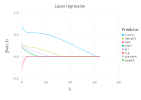

In [8]:
using DataFrames, Gadfly

p = size(Xtr, 2) - 1
lassopath = DataFrame(Predictor = Compat.repeat(["lcavol","lweight","age","lbph",
    "svi","lcp","gleason","pgg45"]; outer = length(λlist)), 
    Coeff = reshape(βhat_l1path[2:end, :], (p * length(λlist))), 
    λ = rep(λlist, each=p))

plot(lassopath, x=:λ, y=:Coeff, color=:Predictor, Geom.line, 
    Guide.XLabel("λ"), Guide.YLabel("βhat(λ)"), 
    Guide.Title("Lasso regression"),
    Scale.color_discrete_hue)

Plot test errors.

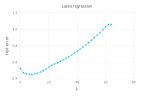

In [9]:
plot(x = λlist, y = err_l1path, Geom.point, Geom.line, 
    Guide.XLabel("λ"), Guide.YLabel("test error"), 
    Scale.x_continuous(minvalue=0, maxvalue=50),
    Guide.Title("Lasso regression"))

## Group lasso on prostate cancer data

Group lasso penalizes the least sqaures by group penalties.
$$
    \frac 12 \|\by - \beta_0 \mathbf{1} - \bX \bbeta\|_2^2 + \lambda \sum_{g=1}^G \sqrt{p_g} \|\bbeta_g\|_2,
$$
where $\bbeta_g$ is the subvector of regression coefficients for group $g$ and $p_g$ are group sizes. This can be formulated as a second-order cone problem (SOCP) and readily solved by Convex.jl.

Read in the prostate cancer data.

In [10]:
prostate = readdlm("prostate.txt", '\t'; header=true)
X = map(Float64, prostate[1][:, 2:9])
y = map(Float64, prostate[1][:, 10])
trainidx = (prostate[1][:, 11] .== "T");

Standardize predictors and add intercept.

In [11]:
X = X .- mean(X, 1)
X = X ./ std(X, 1)
X = [ones(size(X, 1), 1) X];

Add quadratic and cubic terms for continuous predictors.

In [12]:
Xaug = hcat(X[:, 1],                      # intercept
    X[:, 2], X[:, 2].^2, X[:, 2].^3,  # lcavol, lcavol^2, lcavol^3
    X[:, 3], X[:, 3].^2, X[:, 3].^3,  # lweight, lweight^2, lweight^3
    X[:, 4], X[:, 4].^2, X[:, 4].^3,  # age, age^2, age^3
    X[:, 5], X[:, 5].^2, X[:, 5].^3,  # lbph, lbph^2, lbph^3
    X[:, 6],                          # svi
    X[:, 7], X[:, 7].^2, X[:, 7].^3,  # lcp, lcp^2, lcp^3
    X[:, 8],                          # gleason
    X[:, 9], X[:, 9].^2, X[:, 9].^3)  # pgg45, pgg^2, pgg^3
grplabel = [0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 6, 6, 6, 7, 8, 8, 8];

Train/test split.

In [13]:
Xtr = Xaug[trainidx, :]
ytr = y[trainidx]
Xte = Xaug[!trainidx, :]
yte = y[!trainidx];

Solve group lasso over a grid

In [14]:
λlist = 2.^(-3:0.2:7)
βhat_gppath = zeros(size(Xtr, 2), length(λlist))
err_gppath = zeros(1, length(λlist))
@time for i = 1:length(λlist)
    λ = λlist[i]
    βhat_gppath[:, i] = lsqlasso(ytr, Xtr, λ; grouplabel = grplabel)
    err_gppath[i] = norm(yte - Xte * βhat_gppath[:, i])^2 / length(yte)
end

  0.503763 seconds (519.68 k allocations: 90.774 MB, 4.65% gc time)


Plot solution path.

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in #rep#202(::Int64, ::Int64, ::Function, ::Array{Float64,1}) at ./deprecated.jl:50
 in (::DataArrays.#kw##rep)(::Array{Any,1}, ::DataArrays.#rep, ::Array{Float64,1}) at ./<missing>:0
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/huazhou/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /Users/huazhou/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[15], in expression starting on line 4


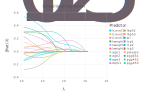

In [15]:
using DataFrames, Gadfly

p = size(Xtr, 2) - 1
lassopath = DataFrame(Predictor = Compat.repeat(["lcavol1", "lcavol2", "lcavol3",
    "lweight1", "lweight2", "lweight3", "age1", "age2", "age3", 
    "lbph1", "lbph2", "lbph3", "svi", "lcp1", "lcp2", "lcp3",
    "gleason", "pgg451", "pgg452", "pgg453"]; outer = length(λlist)),
    Coeff = reshape(βhat_gppath[2:end, :], (p * length(λlist))), 
    λ = rep(λlist, each=p))

plot(lassopath, x=:λ, y=:Coeff, color=:Predictor, Geom.line(),
    Guide.XLabel("λ"), Guide.YLabel("βhat(λ)"), 
    Guide.Title("Groupl lasso regression"),
    Scale.color_discrete_hue, Scale.x_log10)

Plot test errors.

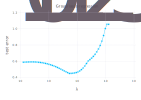

In [16]:
plot(x = λlist, y = err_gppath, Geom.point, Geom.line, 
    Guide.XLabel("λ"), Guide.YLabel("test error"),
    Scale.x_continuous(minvalue=0, maxvalue=100),
    Guide.Title("Groupl lasso regression"), Scale.x_log10)

## SVM on the South African heart disease data

Support vector machines (SVM) minimizes the hinge loss + ridege penalty
$$
    \sum_{i=1}^n \left[ 1 - y_i \left( \beta_0 + \sum_{j=1}^p x_{ij} \beta_j \right) \right]_+ + \lambda \|\bbeta\|_2^2,
$$
a quadratic programing (QP) problem readily modelled by Convex.jl.

In [17]:
#
# This function computes SVM solution with responses y
# and design matrix X
#
function svm(y::Vector{Float64}, X::Matrix{Float64}, 
             λ::Float64, p::Float64=2.0)

  # Create optimization variables
  βhat = Variable(size(X, 2))
  # Set up optmization problem
  if p == 1.0
    # 1-norm SVM
    problem = minimize(sum(pos(1.0 - y .* (X * βhat)))
                       + λ * norm(βhat[2:end], 1))
  elseif p == 2.0
    # regular SVM
    problem = minimize(sum(pos(1.0 - y .* (X * βhat)))
                       + λ * sumsquares(βhat[2:end]))
  end
  # Solve the problem by calling solve
  solve!(problem)
  # Return
  βhat.value

end

svm (generic function with 2 methods)

Read in SA heart data.

In [18]:
saheart = readdlm("saheart.txt", '\t'; header=true)
X = saheart[1][:, 2:10]
X[:, 5] = X[:, 5] .== "Present"
X = map(Float64, X[:, [1, 2, 3, 5, 7, 8, 9]])
y = map(Float64, saheart[1][:, 11])
trainidx = map(Bool, saheart[1][:, 12]);

Standardize predictors and add intercept.

In [19]:
X = X .- mean(X, 1)
X = X ./ std(X, 1)
X = [ones(size(X, 1), 1) X];

Train/test split.

In [20]:
Xtr = X[trainidx, :]
ytr = y[trainidx]
Xte = X[~trainidx, :]
yte = y[~trainidx];

Let's transform 0/1-valued `y` to -1/1-valued class labels.

In [21]:
ctr = 2.0ytr - 1.0
cte = 2.0yte - 1.0;

Solve SVM over a grid.

In [22]:
λlist = map(Float64, 0:2:100)
βhatSVM = zeros(size(Xtr, 2), length(λlist))
errSVM = zeros(1, length(λlist))
@time for i = 1:length(λlist)
    λ = λlist[i]
    βhatSVM[:, i] = svm(ctr, Xtr, λ)
    errSVM[i] = 1.0 - sum(cte .== sign(Xte * βhatSVM[:, i])) / length(cte)
end

  2.964928 seconds (1.08 M allocations: 134.437 MB, 5.38% gc time)


Plot SVM solution path.

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in #rep#202(::Int64, ::Int64, ::Function, ::FloatRange{Float64}) at ./deprecated.jl:50
 in (::DataArrays.#kw##rep)(::Array{Any,1}, ::DataArrays.#rep, ::FloatRange{Float64}) at ./<missing>:0
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/huazhou/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /Users/huazhou/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[23], in expression starting on line 4


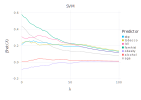

In [23]:
using DataFrames, Gadfly

p = size(Xtr, 2) - 1
svmpath = DataFrame(Predictor = Compat.repeat(["sbp", "tobacco", "ldl", 
    "famhist", "obesity", "alcohol", "age"]; outer = length(λlist)), 
    Coeff = reshape(βhatSVM[2:end, :], (p * length(λlist))), 
    λ = rep(λlist, each=p))

plot(svmpath, x=:λ, y=:Coeff, color=:Predictor, Geom.line, 
    Guide.XLabel("λ"), Guide.YLabel("βhat(λ)"), 
    Guide.Title("SVM"), Scale.color_discrete_hue)

Plot misclassification rate on test set.

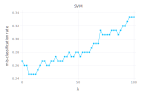

In [24]:
plot(x = λlist, y = errSVM, Geom.point, Geom.line, 
    Guide.XLabel("λ"), Guide.YLabel("mis-classification rate"), 
    Guide.Title("SVM"))

## Complete Lena

Load the $128 \times 128$ Lena picture with missing pixels.

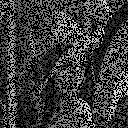

In [25]:
using Images, FileIO

lena = load("lena128missing.png")

In [26]:
Y = reinterpret(Float64, Images.data(map(Float64, lena)));

data(A) is deprecated for arrays that are not an ImageMeta. To avoid
using `data`, structure your code like this:

    function myfunction(img::AbstractArray, args...)
        # "real" algorithm goes here
    end
    myfunction(img::ImageMeta, args...) = myfunction(data(img), args...)

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in data(::Array{Float64,2}) at /Users/huazhou/.julia/v0.5/ImageCore/src/deprecated.jl:88
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/huazhou/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /Users/huazhou/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[26], in expression starting on line 1


We fill out the missin pixels uisng a **matrix completion** technique developed by Candes and Tao
$$
    \text{minimize } \|\bX\|_*
$$
$$
    \text{subject to } x_{ij} = y_{ij} \text{ for all observed entries } (i, j).
$$
Here $\|\bM\|_* = \sum_i \sigma_i(\bM)$ is the nuclear norm. That is we seek the matrix with minimal nuclear norm that agrees with the observed entries. This is a semidefinite programming (SDP) problem readily modeled by Convex.jl.

In [27]:
#
# This function completes a matrix Y by minimizing nuclear norm of X subject to
# the constraint that X[i, j] = Y[i, j] for observed entries (i, j).
#
function matcomp(Y::Matrix{Float64}; mischar::Float64=0.0)

  # Linear indices of obs. entries
  obsidx = find(Y .≠ mischar)

  # Create optimization variables
  X = Convex.Variable(size(Y))
  # Set up optmization problem
  problem = minimize(nuclearnorm(X))
  problem.constraints += X[obsidx] == Y[obsidx]
  # Solve the problem by calling solve
  solve!(problem)
  # Return
  X.value

end

matcomp (generic function with 1 method)

 31.692623 seconds (2.05 M allocations: 319.283 MB, 0.58% gc time)


 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in grayim(::Array{Float64,2}) at /Users/huazhou/.julia/v0.5/ImageCore/src/deprecated.jl:6
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/huazhou/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /Users/huazhou/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[28], in expression starting on line 2


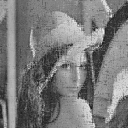

In [28]:
@time lena_complete = matcomp(Y)
grayim(lena_complete)